In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import cv2
import numpy as np
from utils import DataGenerator, preprocess_true_boxes
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf

import cv2
import numpy as np
from models import Yolov4, yolov4_head, get_boxes
from config import yolo_config

In [3]:
with open('../dataset/train_txt/anno.txt') as f:
    lines = f.readlines()

In [4]:
FOLDER_PATH = '..'

In [5]:
lines[0]

'dataset/train_img/BloodImage_00000.jpg 260,177,491,376,0 78,336,184,435,2 63,237,169,336,2 214,362,320,461,2 414,352,506,445,2 555,356,640,455,2 469,412,567,480,2 1,333,87,437,2 4,406,95,480,2 155,74,247,174,2 11,84,104,162,2 534,39,639,139,2 547,195,640,295,2 388,11,481,111,2 171,175,264,275,2 260,1,374,83,2 229,91,343,174,2 69,144,184,235,2 482,131,594,230,2 368,89,464,176,2\n'

In [6]:
data_gen = DataGenerator(lines[:], 1, (416, 416), FOLDER_PATH)

In [7]:
X, y = data_gen.__getitem__(0)

In [8]:
X.shape, y.shape

((1, 416, 416, 3), (1, 100, 5))

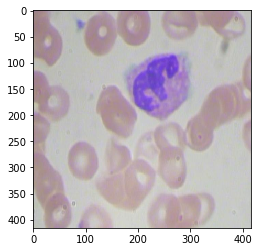

In [9]:
plt.imshow(X[0])

In [10]:
# y[0]

In [11]:
# m = 0
# for i in range(len(data_gen)):
#     X, y = data_gen.__getitem__(i)
#     print(y)
#     break
# #     img = X[0].copy()
# #     for b in y[0][0:]:
# #         b = [int(i) for i in b]
# #         cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
# #     plt.imshow(img)
# #     plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


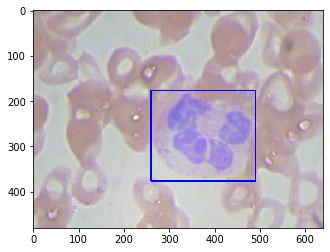

In [12]:
raw = cv2.imread('../dataset/train_img/BloodImage_00000.jpg')[:,:,::-1]
raw = raw / 255.
cv2.rectangle(raw, (260, 177), (491, 376), (0, 0, 255), 2)
plt.imshow(raw) # 260 177 491 376

In [14]:
# y[0, :10]

In [15]:
# def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
#     '''Preprocess true boxes to training input format

#     Parameters
#     ----------
#     true_boxes: array, shape=(m, T, 5)
#         Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
#     input_shape: array-like, hw, multiples of 32
#     anchors: array, shape=(N, 2), wh
#     num_classes: integer

#     Returns
#     -------
#     y_true: list of array, shape like yolo_outputs, xywh are reletive value

#     '''
#     assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
#     num_layers = len(anchors)//3 # default setting
#     print('num_layers ', num_layers)
#     anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

#     true_boxes = np.array(true_boxes, dtype='float32')
#     input_shape = np.array(input_shape, dtype='int32')
#     boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 #(100, 2) (100, 2)
#     boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
#     print('boxes_xy boxes_wh', boxes_xy.shape, boxes_wh.shape)
#     true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
#     true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

#     m = true_boxes.shape[0] # bs: 1
#     print('m ', m)
#     grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
#     y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
#         dtype='float32') for l in range(num_layers)] # (100, 13, 13, 3, 8) (100, 26, 26, 3, 8) (100, 52, 52, 3, 8)
#     for i in range(3):
#         print(f'y {i}', y_true[i].shape)

#     # Expand dim to apply broadcasting.
#     anchors = np.expand_dims(anchors, 0) # 1, 9 , 2
#     print('anchors ', anchors.shape, anchors) 
#     anchor_maxes = anchors / 2.
#     anchor_mins = -anchor_maxes
#     print(anchor_maxes)
#     valid_mask = boxes_wh[..., 0]>0  # 100,
#     print('valid mask', valid_mask.shape) 

#     for b in range(m):
#         # Discard zero rows.
#         wh = boxes_wh[b, valid_mask[b]]  # (1, 2)
#         print('wh', wh.shape)
#         if len(wh)==0: continue
#         # Expand dim to apply broadcasting.
#         wh = np.expand_dims(wh, -2) # (1, 1, 2)
#         print('wh', wh.shape)
# #         print(wh) # 76. 102
#         box_maxes = wh / 2. # (1, 1, 2)
#         box_mins = -box_maxes # (1, 1, 2)
# #         print(box_maxes, box_mins) # [[[38. 51.]]] [[[-38. -51.]]]
#         print('box_mins, anchor_mins', box_mins.shape, anchor_mins.shape)
#         intersect_mins = np.maximum(box_mins, anchor_mins)
#         intersect_maxes = np.minimum(box_maxes, anchor_maxes)
#         print('intersect_mins', intersect_mins.shape)
# #         print('intersect_mins', 'intersect_max', intersect_mins, intersect_maxes)
#         intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
# #         print(intersect_wh)
#         intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # (9,)
#         print('intersect_area ', intersect_area)
# #         print(intersect_area)
#         box_area = wh[..., 0] * wh[..., 1]
#         print('box_area ', box_area.shape)
#         anchor_area = anchors[..., 0] * anchors[..., 1] # 1, 9
#         print('anchor_area', anchor_area.shape)
#         iou = intersect_area / (box_area + anchor_area - intersect_area)
#         print('iou', iou.shape)

#         # Find best anchor for each true box
#         best_anchor = np.argmax(iou, axis=-1)
#         print('best_anchor', best_anchor, best_anchor.shape)
#         print('true_boxes ', true_boxes.shape)
#         for t, n in enumerate(best_anchor): # t: idx, n:anchor idx
#             for l in range(num_layers): # 3
#                 if n in anchor_mask[l]:
#                     print('true_boxes[b,t,0]', true_boxes[b,t,0], b, t, 'grid_shapes[l]', grid_shapes[l])
#                     i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32') # grid index
#                     j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32') # grid index 
#                     print(i, j)
#                     k = anchor_mask[l].index(n)
#                     c = true_boxes[b,t, 4].astype('int32')
#                     y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4] # bbox
#                     y_true[l][b, j, i, k, 4] = 1 # confidence
#                     y_true[l][b, j, i, k, 5+c] = 1 # one hot

#     return y_true

In [19]:
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))
a = preprocess_true_boxes(y[:1], (416, 416), anchors, num_classes=3)

In [20]:
len(a)
a[0].shape, a[1].shape, a[2].shape

((1, 52, 52, 3, 8), (1, 26, 26, 3, 8), (1, 13, 13, 3, 8))

In [36]:
# yolo_config

In [37]:
model = Yolov4(
                weight_path=None,
                class_name_path='bccd_classes.txt'
#               weight_path='yolov4.weights',

#                img_size=(416, 416, 3),
            
              )
model.build_model()

In [38]:
# def yolo_loss(y_pred, y_true, anchors, num_classes, ignore_thresh=.5, print_loss=False):
#     '''Return yolo_loss tensor

#     Parameters
#     ----------
#     yolo_outputs: list of tensor, the output of yolo_body or tiny_yolo_body
#     y_true: list of array, the output of preprocess_true_boxes
#     anchors: array, shape=(N, 2), wh
#     num_classes: integer
#     ignore_thresh: float, the iou threshold whether to ignore object confidence loss

#     Returns
#     -------
#     loss: tensor, shape=(1,)

#     '''
# #     num_layers = len(anchors)//3 # default setting
#     num_layers = 3
#     xyscale = [1.2, 1.1, 1.05]
# #     yolo_outputs = args[:num_layers]
#     yolo_outputs = y_pred
# #     y_true = args[num_layers:]
# #     y_true 
# #     anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]
#     anchor_mask = [[0,1,2], [3,4,5], [6,7,8]]
#     input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0]))
#     grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
#     # (1, 52, 52, 3, 8), (1, 26, 26, 3, 8), (1, 13, 13, 3, 8)
#     # -> (52, 52), (26, 26) (13, 13)
#     loss = 0
#     m = K.shape(yolo_outputs[0])[0] # batch size, tensor
#     mf = K.cast(m, tf.float32)
# #     mf = K.cast(m, K.dtype(yolo_outputs[0]))

#     for l in range(num_layers):
#         object_mask = y_true[l][..., 4:5]
#         true_class_probs = y_true[l][..., 5:]
#         # grid = [[gridx gridy index]]
# #         grid, raw_pred, pred_xy, pred_wh = yolo_head(yolo_outputs[l],
# #              anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
#         bbox0, object_probability0, class_probabilities0, pred_box0 = get_boxes(yolo_outputs[l],
#                                                                             anchors=anchors[0, :, :], classes=num_classes,
#                                                                             grid_size=52, strides=8,
#                                                                             xyscale=xyscale[0])
# #         pred_box = K.concatenate([pred_xy, pred_wh])
#         pred_box = pred_box0
        

#         # Darknet raw box to calculate loss.
#         # y_true_xy (0~1)
#         print('y_true[l][..., :2] ', y_true[l][..., :2], y_true[l][..., :2].shape)
#         print('grid_shapes[l][::-1] ', grid_shapes[l][::-1], grid_shapes[l][::-1].shape)
# #         print('grid ', grid.shape)
#         raw_true_xy = y_true[l][..., :2]*grid_shapes[l][::-1] - grid # raw_true_xy: xy positiion in grid (0~1)
#         raw_true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
#         raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
#         box_loss_scale = 2 - y_true[l][...,2:3]*y_true[l][...,3:4]

#         # Find ignore mask, iterate over each of batch.
#         ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
#         object_mask_bool = K.cast(object_mask, 'bool')
#         def loop_body(b, ignore_mask):
#             true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
#             iou = box_iou(pred_box[b], true_box)
#             best_iou = K.max(iou, axis=-1)
#             ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
#             return b+1, ignore_mask
# #        _, ignore_mask = K.control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
#         _, ignore_mask = control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
#         ignore_mask = ignore_mask.stack()
#         ignore_mask = K.expand_dims(ignore_mask, -1)

#         # K.binary_crossentropy is helpful to avoid exp overflow.
#         xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
#         wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
#         confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
#             (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
#         class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)

#         xy_loss = K.sum(xy_loss) / mf
#         wh_loss = K.sum(wh_loss) / mf
#         confidence_loss = K.sum(confidence_loss) / mf
#         class_loss = K.sum(class_loss) / mf
#         loss += xy_loss + wh_loss + confidence_loss + class_loss
#         if print_loss:
#             loss = tf.Print(loss, [loss, xy_loss, wh_loss, confidence_loss, class_loss, K.sum(ignore_mask)], message='loss: ')
#     return loss

In [108]:
def broadcast_iou(box_1, box_2):
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)
    int_w = tf.maximum(
        tf.minimum(box_1[..., 2], box_2[..., 2])
        - tf.maximum(box_1[..., 0], box_2[..., 0]),
        0,
    )
    int_h = tf.maximum(
        tf.minimum(box_1[..., 3], box_2[..., 3])
        - tf.maximum(box_1[..., 1], box_2[..., 1]),
        0,
    )
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * (
        box_1[..., 3] - box_1[..., 1]
    )
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * (
        box_2[..., 3] - box_2[..., 1]
    )
    return int_area / (box_1_area + box_2_area - int_area)

def yolo_loss(y_true, y_pred, num_classes, anchors, xyscale=[1.2, 1.1, 1.05], ignore_thresh=0.5):
#     get_boxes(yolo_neck_outputs[0],
#             anchors=anchors[0, :, :], classes=80,
#             grid_size=52, strides=8,
#             xyscale=xyscale[0])
    yolo_outputs = tf.cast(y_pred[0], tf.float32)
    y_true = y_true[0]
    anchors = anchors[0]
    print('yolo_outputs ', yolo_outputs.shape, 'y_true', y_true.shape)
    bbox0, object_probability0, class_probabilities0, pred_box0 = get_boxes(yolo_outputs,
                                                                    anchors=anchors, classes=num_classes,
                                                                    grid_size=52, strides=8,
                                                                    xyscale=xyscale[0])
#     pred_box, pred_obj, pred_class, pred_xywh = get_boxes(
#         y_pred, anchors, classes
#     )
    pred_box = bbox0
    pred_obj = object_probability0
    pred_class = class_probabilities0
    pred_xywh = pred_box0
    pred_xy = pred_xywh[..., 0:2]
    pred_wh = pred_xywh[..., 2:4]
#     true_box, true_obj, true_class_idx = tf.split(
#         y_true, (4, 1, 1), axis=-1
#     )
    true_box = y_true[..., :4]
    true_obj = y_true[..., 4]
    true_classes = y_true[..., 5:]
    print('true_classes ', true_classes.shape)
#     true_class_idx
#     true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
#     true_wh = true_box[..., 2:4] - true_box[..., 0:2]
    true_xy = true_box[..., :2]
    true_wh = true_box[..., 2:4]
    
    box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
    grid_size = tf.shape(y_true)[1]
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
    true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(
        grid, tf.float32
    )
#     true_wh  (1, 52, 52, 3, 2)
#     anchors  (3, 2)
    true_wh = tf.math.log(true_wh / anchors)
    true_wh = tf.where(
        tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh
    )
    true_wh = tf.cast(true_wh, tf.float32)
#     true obj  (1, 52, 52, 3)
#     obj_mask = tf.squeeze(true_obj, -1)
    obj_mask = true_obj
    print('pred_box, true_box, obj_mask', pred_box.shape, true_box.shape, obj_mask.shape)
    # pred_box, true_box, obj_mask (1, 52, 52, 3, 4) (1, 52, 52, 3, 4) (1, 52, 52, 3)
    best_iou = tf.map_fn(
        lambda x: tf.reduce_max(
            broadcast_iou(
                x[0], tf.boolean_mask(x[1], tf.cast(x[2], tf.bool))
            ),
            axis=-1,
        ),
        (pred_box, true_box, obj_mask),
        tf.float32,
    )
    ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
    xy_loss = (
        obj_mask
        * box_loss_scale
        * tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
    )
    wh_loss = (
        obj_mask
        * box_loss_scale
        * tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
    )
    print('true_obj pred_obj', true_obj.shape, pred_obj.shape)
    # true_obj pred_obj (1, 52, 52, 3) (1, 52, 52, 3, 1)
    obj_loss = tf.keras.losses.binary_crossentropy(tf.expand_dims(true_obj, -1), pred_obj)
    print('obj_mask, obj_loss, ignore_mask', obj_mask.shape, obj_loss.shape, ignore_mask.shape)
    # obj_mask, obj_loss, ignore_mask (1, 52, 52, 3) (1, 52, 52, 3) (1, 52, 52, 3)
    obj_loss = (
        obj_mask * obj_loss + (1 - obj_mask) * ignore_mask * obj_loss
    )
    print('pred_class ', pred_class.shape)
    class_loss = obj_mask * tf.keras.losses.categorical_crossentropy(
        true_classes, pred_class
    )
    xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
    wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
    obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
    class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))
    return xy_loss + wh_loss + obj_loss + class_loss

In [40]:
x_batch, y_batch = X, y = data_gen.__getitem__(0)

In [41]:
x_batch.shape, y_batch.shape

((1, 416, 416, 3), (1, 100, 5))

In [42]:
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))
y_true = preprocess_true_boxes(y, (416, 416), anchors, num_classes=3)

In [81]:
y_true[0].shape, y_true[1].shape, y_true[2].shape
model.yolo_model.input, model.yolo_model.output, y_true[0].dtype

(<tf.Tensor 'input_2:0' shape=(?, 416, 416, 3) dtype=float32>,
 [<tf.Tensor 'conv2d_203/BiasAdd:0' shape=(?, 52, 52, 24) dtype=float32>,
  <tf.Tensor 'conv2d_211/BiasAdd:0' shape=(?, 26, 26, 24) dtype=float32>,
  <tf.Tensor 'conv2d_219/BiasAdd:0' shape=(?, 13, 13, 24) dtype=float32>],
 dtype('float32'))

In [44]:
model.yolo_model.input, model.yolo_model.output

(<tf.Tensor 'input_2:0' shape=(?, 416, 416, 3) dtype=float32>,
 [<tf.Tensor 'conv2d_203/BiasAdd:0' shape=(?, 52, 52, 24) dtype=float32>,
  <tf.Tensor 'conv2d_211/BiasAdd:0' shape=(?, 26, 26, 24) dtype=float32>,
  <tf.Tensor 'conv2d_219/BiasAdd:0' shape=(?, 13, 13, 24) dtype=float32>])

In [78]:
y_pred = model.yolo_model(x_batch)

y_pred[0], y_pred[0].shape, y_pred[1].shape, y_pred[2].shape

(<tf.Tensor 'model_4_2/conv2d_203/BiasAdd:0' shape=(1, 52, 52, 24) dtype=float32>,
 TensorShape([Dimension(1), Dimension(52), Dimension(52), Dimension(24)]),
 TensorShape([Dimension(1), Dimension(26), Dimension(26), Dimension(24)]),
 TensorShape([Dimension(1), Dimension(13), Dimension(13), Dimension(24)]))

In [109]:
yolo_loss(y_true, y_pred, num_classes=3, anchors=anchors.reshape(3, 3, 2))

yolo_outputs  (1, 52, 52, 24) y_true (1, 52, 52, 3, 8)
true_classes  (1, 52, 52, 3, 3)
pred_box, true_box, obj_mask (1, 52, 52, 3, 4) (1, 52, 52, 3, 4) (1, 52, 52, 3)
true_obj pred_obj (1, 52, 52, 3) (1, 52, 52, 3, 1)
obj_mask, obj_loss, ignore_mask (1, 52, 52, 3) (1, 52, 52, 3) (1, 52, 52, 3)
pred_class  (1, 52, 52, 3, 3)


<tf.Tensor 'add_121:0' shape=(1,) dtype=float32>